# Classification

## Sources

src: https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390

## Imports

In [47]:
# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# data handling
import pandas as pd
import numpy as np
import time
from scipy.stats import randint
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# interpretation
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import plot_partial_dependence

## Prepare Data

In [48]:
trainDF = pd.read_csv('../app/data/02_train.csv', sep=';')
testDF = pd.read_csv('../app/data/02_test.csv', sep=';')

>Prepare for classification by creating ranges for the totalPrice column

In [49]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219943 entries, 0 to 219942
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Lng                     219943 non-null  float64
 1   Lat                     219943 non-null  float64
 2   square                  219943 non-null  float64
 3   livingRoom              219943 non-null  int64  
 4   drawingRoom             219943 non-null  int64  
 5   kitchen                 219943 non-null  int64  
 6   bathRoom                219943 non-null  int64  
 7   floor                   219943 non-null  int64  
 8   buildingType            219943 non-null  int64  
 9   renovationCondition     219943 non-null  int64  
 10  buildingStructure       219943 non-null  int64  
 11  ladderRatio             219943 non-null  float64
 12  elevator                219943 non-null  float64
 13  fiveYearsProperty       219943 non-null  float64
 14  subway              

In [50]:
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94262 entries, 0 to 94261
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Lng                     94262 non-null  float64
 1   Lat                     94262 non-null  float64
 2   square                  94262 non-null  float64
 3   livingRoom              94262 non-null  int64  
 4   drawingRoom             94262 non-null  int64  
 5   kitchen                 94262 non-null  int64  
 6   bathRoom                94262 non-null  int64  
 7   floor                   94262 non-null  int64  
 8   buildingType            94262 non-null  int64  
 9   renovationCondition     94262 non-null  int64  
 10  buildingStructure       94262 non-null  int64  
 11  ladderRatio             94262 non-null  float64
 12  elevator                94262 non-null  float64
 13  fiveYearsProperty       94262 non-null  float64
 14  subway                  94262 non-null

In [51]:
trainDF.describe().totalPrice

count    219943.000000
mean        350.116172
std         232.890170
min           0.100000
25%         205.000000
50%         295.000000
75%         428.000000
max       18130.000000
Name: totalPrice, dtype: float64

In [52]:
testDF.describe().totalPrice

count    94262.000000
mean       349.123993
std        228.231882
min          0.100000
25%        204.625000
50%        294.000000
75%        425.000000
max       5700.000000
Name: totalPrice, dtype: float64

In [53]:
bins = [i for i in range(0, 1010, 20)]
bins.append(float('Inf'))

labels = [i for i in range(0, len(bins)-1, 1)]  # Bin labels must be one fewer than the number of bin edges

idx=0
totalPriceMapping = {}
for i in labels:
    totalPriceMapping[labels[idx]]=f"{bins[idx]} - {bins[idx+1]}"
    idx+=1

print("bins:", bins)
print("labels:", labels)
print("\ntotalPrice mapping:")
print(totalPriceMapping)

bins: [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, inf]
labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

totalPrice mapping:
{0: '0 - 20', 1: '20 - 40', 2: '40 - 60', 3: '60 - 80', 4: '80 - 100', 5: '100 - 120', 6: '120 - 140', 7: '140 - 160', 8: '160 - 180', 9: '180 - 200', 10: '200 - 220', 11: '220 - 240', 12: '240 - 260', 13: '260 - 280', 14: '280 - 300', 15: '300 - 320', 16: '320 - 340', 17: '340 - 360', 18: '360 - 380', 19: '380 - 400', 20: '400 - 420', 21: '420 - 440', 22: '440 - 460', 23: '460 - 480', 24: '480 - 500', 25: '500 - 520', 26: '520 - 540', 27: '540 - 560', 28: '560 - 580', 29: '580 - 600', 30: '600 - 620', 31: '6

In [54]:
trainDF['totalPrice'] = pd.cut(trainDF['totalPrice'], bins=bins, labels=labels)  # change totalPrice column to categorial feature with above devined ranges/labels
testDF['totalPrice'] = pd.cut(testDF['totalPrice'], bins=bins, labels=labels)  # change totalPrice column to categorial feature with above devined ranges/labels

In [55]:
trainDF.head(10)

,Lng,Lat,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,renovationCondition,...,placeRank,town,districtPopulation,districtArea,tradeYear,tradeMonth,tradeDay,floorType,constructionTimePeriod,totalPrice
0,116.346109,39.756539,73.61,3,1,1,1,6,118742,53150,...,133606,219943,1993591.0,1012.0,2017,8,6,82499,136686,17
1,116.423426,39.964365,58.29,2,1,1,1,5,118742,81641,...,133606,219943,3452460.0,470.8,2013,5,14,82499,136686,15
2,116.513137,39.978272,94.47,2,1,1,1,9,118742,81641,...,133606,219943,3452460.0,470.8,2012,12,29,18058,136686,15
3,116.473376,39.875385,131.63,3,1,1,2,22,58087,53150,...,81988,219943,3452460.0,470.8,2015,4,9,25725,136686,20
4,116.471931,40.008739,103.14,3,2,1,1,18,58087,53150,...,81988,219943,3452460.0,470.8,2017,12,7,82499,136686,33
5,116.387037,39.959170,52.21,1,1,1,1,6,118742,81441,...,133606,219943,708829.0,40.6,2014,10,25,82499,13370,14
6,116.365511,40.036171,85.63,2,1,1,1,13,58087,81641,...,133606,219943,3133469.0,426.0,2012,6,23,48571,136686,10
7,116.378897,40.015057,51.31,1,1,1,1,14,41617,81441,...,81988,219943,3452460.0,470.8,2017,4,20,82499,136686,19
8,116.587907,39.920397,66.03,2,1,1,1,7,118742,53150,...,133606,219943,3452460.0,470.8,2015,2,9,18058,136686,9
9,116.411493,40.000186,106.92,2,2,1,1,15,41617,81441,...,81988,219943,3452460.0,470.8,2017,7,25,44240,136686,38


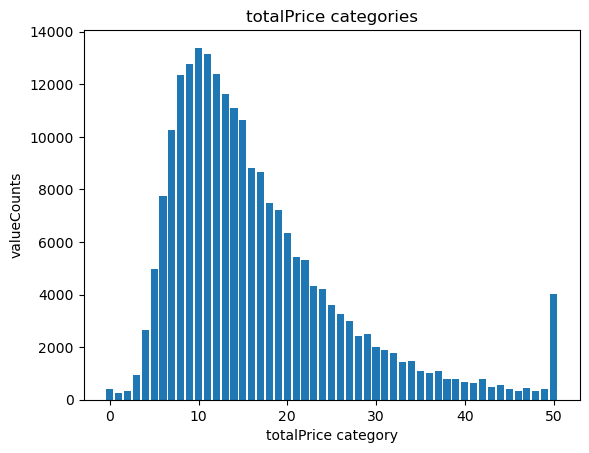

In [56]:
plt.bar(trainDF["totalPrice"].value_counts().index, trainDF["totalPrice"].value_counts().values)
plt.title("totalPrice categories")
plt.xlabel("totalPrice category")
plt.ylabel("valueCounts")
plt.show()

In [57]:
columns = trainDF.columns.to_list()
print(columns)

['Lng', 'Lat', 'square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor', 'buildingType', 'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district', 'communityAverage', 'placeRank', 'town', 'districtPopulation', 'districtArea', 'tradeYear', 'tradeMonth', 'tradeDay', 'floorType', 'constructionTimePeriod', 'totalPrice']


In [58]:
X_train = trainDF.drop(['totalPrice'], axis=1)
y_train = trainDF['totalPrice']
X_test = testDF.drop(['totalPrice'], axis=1)
y_test = testDF['totalPrice']

In [59]:
X_train

,Lng,Lat,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,renovationCondition,...,communityAverage,placeRank,town,districtPopulation,districtArea,tradeYear,tradeMonth,tradeDay,floorType,constructionTimePeriod
0,116.346109,39.756539,73.61,3,1,1,1,6,118742,53150,...,39243.0,133606,219943,1993591.0,1012.0,2017,8,6,82499,136686
1,116.423426,39.964365,58.29,2,1,1,1,5,118742,81641,...,92516.0,133606,219943,3452460.0,470.8,2013,5,14,82499,136686
2,116.513137,39.978272,94.47,2,1,1,1,9,118742,81641,...,73113.0,133606,219943,3452460.0,470.8,2012,12,29,18058,136686
3,116.473376,39.875385,131.63,3,1,1,2,22,58087,53150,...,54612.0,81988,219943,3452460.0,470.8,2015,4,9,25725,136686
4,116.471931,40.008739,103.14,3,2,1,1,18,58087,53150,...,57510.0,81988,219943,3452460.0,470.8,2017,12,7,82499,136686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219938,116.451461,39.949365,57.49,2,1,1,1,6,118742,81641,...,72137.0,81988,219943,3452460.0,470.8,2012,12,15,48571,136686
219939,116.229624,39.915004,44.10,1,1,1,1,6,118742,81641,...,51471.0,81988,219943,3133469.0,426.0,2012,7,7,82499,16497
219940,116.310205,39.987486,138.14,3,2,1,2,16,58087,81641,...,79927.0,81988,219943,3133469.0,426.0,2011,12,5,44240,136686
219941,116.389264,39.886874,96.90,2,1,2,1,16,58087,81441,...,91507.0,4349,219943,1106214.0,46.5,2015,3,21,44240,136686


In [60]:
y_train

0         17
1         15
2         15
3         20
4         33
          ..
219938    10
219939     5
219940    11
219941    24
219942    14
Name: totalPrice, Length: 219943, dtype: category
Categories (51, int64): [0 < 1 < 2 < 3 ... 47 < 48 < 49 < 50]

## ML

### XGBClassifier

src: https://medium.com/grabngoinfo/hyperparameter-tuning-for-xgboost-91449869c57e

#### GridSearchCV

In [72]:
# Initiate XGBoost Classifier
xgboost = XGBClassifier()
# Define the search space
param_grid = {"colsample_bytree": [0.3, 0.5, 0.8],  # Percentage of columns to be randomly samples for each tree
              "reg_alpha": [0, 0.5, 1, 5],  # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
              "reg_lambda": [0, 0.5, 1, 5]  # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
              }
scoring = ['f1_micro']  # Set up score
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)  # Set up the k-fold cross-validation

In [ ]:
# Define grid search
grid_search = GridSearchCV(estimator=xgboost, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
grid_result = grid_search.fit(X_train, y_train)  # Fit grid search
grid_result  # Print grid search summary

In [ ]:
# Print the best score and the corresponding hyperparameters
print(f'The best score is {grid_result.best_score_}')
print(f'The best hyperparameters are {grid_result.best_params_}')

In [ ]:
# Make prediction using the best model
grid_predict = grid_search.predict(X_test)
accuracy_score(y_test, grid_predict)

#### RandomizedSearchCV

In [38]:
# Initiate XGBoost Classifier
xgboost = XGBClassifier()
# Define the search space
param_grid = {"learning_rate": [0.0001,0.001, 0.01, 0.1, 1],  # Learning rate shrinks the weights to make the boosting process more conservative
              "max_depth": range(3,21,3),  # Maximum depth of the tree, increasing it increases the model complexity
              "gamma": [i/10.0 for i in range(0,5)],  # Gamma specifies the minimum loss reduction required to make a split
              "colsample_bytree": [i/10.0 for i in range(3,10)],  # Percentage of columns to be randomly samples for each tree
              "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],  # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
              "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]  # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
              }
# Set up score
scoring = ['f1_micro']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
# Define random search
random_search = RandomizedSearchCV(estimator=xgboost, 
                                   param_distributions=param_grid, 
                                   n_iter=1,
                                   scoring=scoring, 
                                   n_jobs=-1, 
                                   cv=kfold, 
                                   verbose=0)
random_result = random_search.fit(X_train, y_train)  # Fit grid search
random_result  # Print grid search summary

In [ ]:
# Print the best score and the corresponding hyperparameters
print(f'The best score is {random_result.best_score_}')
print(f'The best hyperparameters are {random_result.best_params_}')

In [ ]:
# Make prediction using the best model
random_predict = random_search.predict(X_test)
accuracy_score(y_test, grid_predict)

#### Final

In [16]:
clf = XGBClassifier(n_jobs=-1)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
accuracy_score(y_test, y_pred)

/home/gregorleandr@edu.local/anaconda3/envs/cds106/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:42:56] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.29153847785958287

### RandomForestClassifier

#### RandomizedSearchCV

In [34]:
clf = RandomForestClassifier()
grid_space={'max_depth':list(np.arange(20, 40, step=10)) + [None],
              'n_estimators':np.arange(100, 300, step=50),
              'max_features':randint(5,len(X_train.columns.tolist())),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(1, 5, step=1)
          }
grid = RandomizedSearchCV(clf,param_distributions=grid_space,cv=3,n_iter=3,scoring='accuracy', n_jobs=-1)
model_grid = grid.fit(X_train,y_train)
print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

Best hyperparameters are: {'criterion': 'entropy', 'max_depth': None, 'max_features': 16, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Best score is: 0.32745302230494544


In [35]:
print(f'Train Accuracy: {grid.score(X_train,y_train):.3f}')
print(f'Test Accuracy: {grid.score(X_test,y_test):.3f}')

Train Accuracy: 0.955
Test Accuracy: 0.345


#### GridSearchCV

In [16]:
clf = RandomForestClassifier()
grid_space={'max_depth':[10,15,20,25],
            'n_estimators':[150,200,250,300],
            'max_features':[9,11,13,15,17,19,21,23,25],
            'min_samples_leaf':[1,2,3],
            'min_samples_split':[2,3,4]
            }
grid = GridSearchCV(clf,param_grid=grid_space,cv=3,scoring='accuracy')
model_grid = grid.fit(X_train,y_train)
print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

/home/gregorleandr@edu.local/anaconda3/envs/cds106/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gregorleandr@edu.local/anaconda3/envs/cds106/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
810 fits failed out of a total of 2430.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gregorleandr@edu.local/anaconda3/envs/cds106/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_

Best hyperparameters are: {'max_depth': 30, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}
Best score is: 0.3116943795241715


In [17]:
print(f'Train Accuracy: {grid.score(X_train,y_train):.3f}')
print(f'Test Accuracy: {grid.score(X_test,y_test):.3f}')

Train Accuracy - : 0.999
Test Accuracy - : 0.329


#### Final

In [36]:
clf = RandomForestClassifier(max_depth=10, max_features=16, min_samples_leaf=3, min_samples_split=2, n_estimators=200)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print('Train Accuracy - :', accuracy_score(y_train, clf.predict(X_train)))
print('Test Accuracy - :', accuracy_score(y_test, y_pred))

Train Accuracy - : 0.3172594717722319
Test Accuracy - : 0.27001336699836626


In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       201
           1       0.79      0.28      0.41       112
           2       0.58      0.44      0.50       165
           3       0.70      0.46      0.55       417
           4       0.60      0.41      0.49      1164
           5       0.51      0.46      0.48      2213
           6       0.45      0.44      0.45      3263
           7       0.43      0.44      0.43      4400
           8       0.40      0.41      0.41      5296
           9       0.35      0.34      0.34      5517
          10       0.33      0.38      0.35      5828
          11       0.28      0.27      0.27      5514
          12       0.27      0.30      0.29      5346
          13       0.25      0.25      0.25      5013
          14       0.22      0.22      0.22      4703
          15       0.23      0.34      0.27      4653
          16       0.20      0.08      0.11      3798
          17       0.20    

/home/gregorleandr@edu.local/anaconda3/envs/cds106/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gregorleandr@edu.local/anaconda3/envs/cds106/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gregorleandr@edu.local/anaconda3/envs/cds106/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(25,25))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = bins  # defined above
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
# DF with predictions
predDF = X_test
predDF["totalPrice"] = y_test
predDF["prediction"] = y_pred
predDF.head()

In [ ]:
predDF["totalPrice"].describe()

In [ ]:
predDF["prediction"].describe()

## Visualization & Interpretation

In [ ]:
columns=['square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor', 'buildingType', 'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district', 'communityAverage', 'placeRank', 'town', 'districtPopulation', 'districtArea', 'tradeYear', 'tradeMonth', 'tradeDay', 'floorType', 'constructionTimePeriod']

plt.figure(figsize=(25,25))
i=0
for groupByFeature in columns:
    i+=1
    plt.subplot(6,4,i)
    plt.scatter(predDF.groupby(["prediction"]).mean().index, predDF.groupby(["prediction"]).mean()[groupByFeature])
    plt.title(f"grouped by {groupByFeature}")
    plt.xlabel("prediction")
    plt.ylabel(groupByFeature)
    plt.xticks([i for i in range(0, len(bins)+1, 5)])
plt.tight_layout()
plt.show()